<a href="https://colab.research.google.com/github/ArifWijayanto/Wireless-Power-Transfer-Modelling-No-Compensation-Circuit/blob/main/UTS_CPS_Muhammad_Arif_Wijayanto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. KCL & KVL Analysis**

Persamaan Rangkaian:

- Primary Loop:
\begin{align*}
V_1 = I_1 (R_1 + s L_T) + s M I_2
\end{align*}

- Secondary Loop:
\begin{align*}
0 = I_2 (R_2 + R_B + s L_R) + s M I_1
\end{align*}

In [2]:
import sympy as sp

# Definisi simbol
R1, R2, RB, LT, LR, K, M, s = sp.symbols('R1 R2 RB LT LR K M s')
I1, I2, V1 = sp.symbols('I1 I2 V1')

# Mutual inductance
M_expr = K * sp.sqrt(LT * LR)

# Persamaan KVL
eq1 = V1 - I1*(R1 + s*LT) - s*M_expr*I2
eq2 = -I2*(R2 + RB + s*LR) - s*M_expr*I1

sol = sp.solve([eq1, eq2], [I1, I2])
I1_expr = sol[I1]
I2_expr = sol[I2]

# Transfer function
Vout = I2_expr * RB
H = Vout / V1

**2. State Space Model**

Matriks State-Space:
\begin{align*}
\mathbf{A} &= \frac{1}{L_T L_R - M^2} \begin{bmatrix}
-L_R R_1 & M (R_2 + R_B) \\
M R_1 & -L_T (R_2 + R_B)
\end{bmatrix}, \\
\mathbf{B} &= \frac{1}{L_T L_R - M^2} \begin{bmatrix} L_R \\ -M \end{bmatrix}, \\
\mathbf{C} &= \begin{bmatrix} 0 & R_B \end{bmatrix}, \quad \mathbf{D} = 0
\end{align*}

In [3]:
det = LT*LR - M_expr**2
A = sp.Matrix([
    [-LR*R1/det, M_expr*(R2 + RB)/det],
    [M_expr*R1/det, -LT*(R2 + RB)/det]
])
B = sp.Matrix([LR/det, -M_expr/det])
C = sp.Matrix([[0, RB]])
D = sp.Matrix([0])

**3. Transfer Function**

- Fungsi Alih Simbolik:
\begin{align*}
H(s) = \frac{-s M R_B}{(R_2 + R_B + s L_R)(R_1 + s L_T) + s^2 M^2}
\end{align*}

- Substitusi Nilai Numerik:
\begin{align*}
R_1 &= 1.2 \, \Omega, \quad R_2 = 1.6 \, \Omega, \quad R_B = 1 \, \text{k}\Omega, \\
L_T &= 63.46 \, \mu\text{H}, \quad L_R = 29.2 \, \mu\text{H}, \quad K = 0.6
\end{align*}

In [6]:
component_values = {
    R1: 1.2,
    R2: 1.6,
    RB: 1e3,
    LT: 63.46e-6,
    LR: 29.2e-6,
    K: 0.6
}
H_numeric = H.subs(component_values).simplify()

**4. Respon Frekuensi**

- Evaluasi pada Domain Frekuensi:
\begin{align*}
H(j\omega) = \left. H(s) \right|_{s = j\omega}
\end{align*}

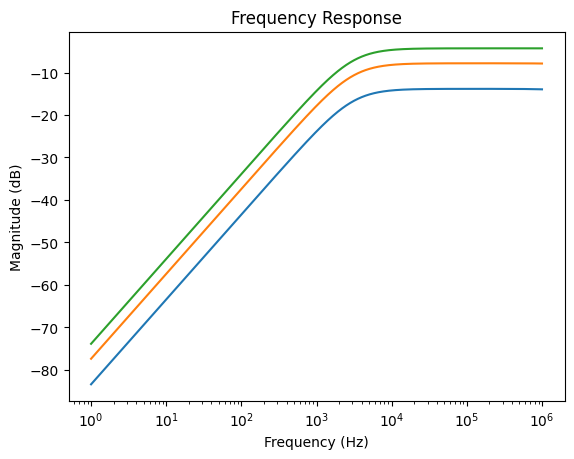

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# Definisi simbol dan substitusi nilai komponen (kecuali K)
R1, R2, RB, LT, LR, K, s = sp.symbols('R1 R2 RB LT LR K s')
component_values = {
    R1: 1.2,
    R2: 1.6,
    RB: 1e3,
    LT: 63.46e-6,
    LR: 29.2e-6
}
H_numeric = H.subs(component_values).simplify()  # K masih simbol

# Fungsi transfer dengan parameter s dan K
H_func = sp.lambdify((s, K), H_numeric, 'numpy')

# Evaluasi untuk K berbeda
omega = np.logspace(0, 6, 2000)  # Frekuensi dalam Hz
K_values = [0.3, 0.6, 0.9]

plt.figure()
for K_val in K_values:
    s_vals = 1j * 2 * np.pi * omega  # Konversi Hz ke rad/s
    H_eval = H_func(s_vals, K_val)    # Evaluasi dengan s dan K
    plt.semilogx(omega, 20 * np.log10(np.abs(H_eval)))

plt.title('Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.show()

**5. Respon Waktu**

- Persamaan State-Space Numerik:
\begin{align*}
\frac{d}{dt}\begin{bmatrix} i_1 \\ i_2 \end{bmatrix} &= \mathbf{A} \begin{bmatrix} i_1 \\ i_2 \end{bmatrix} + \mathbf{B} V_1(t), \\
V_1(t) &= 12 \sin(2\pi \cdot 582193 \cdot t)
\end{align*}

- Output Tegangan:
\begin{align*}
V_{\text{out}}(t) = R_B \cdot i_2(t)
\end{align*}

Text(0, 0.5, 'Vout (V)')

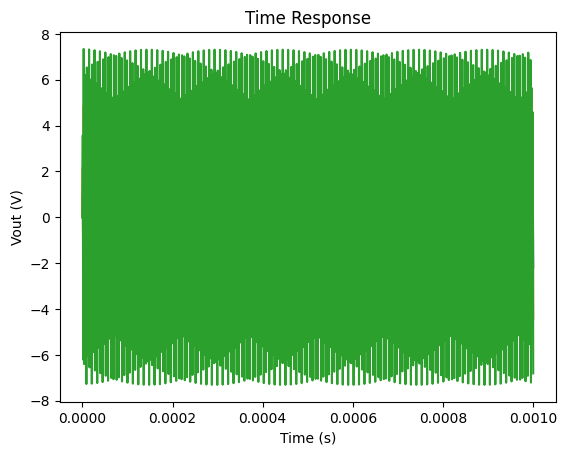

In [9]:
from scipy.integrate import odeint

def model(x, t, K_val):
    # Substitusi nilai K
    M_val = K_val * np.sqrt(63.46e-6 * 29.2e-6)
    det_val = (63.46e-6 * 29.2e-6) - M_val**2
    A = np.array([
        [-(29.2e-6 * 1.2)/det_val, (M_val * (1.6 + 1e3))/det_val],
        [(M_val * 1.2)/det_val, -(63.46e-6 * (1.6 + 1e3))/det_val]
    ])
    B = np.array([29.2e-6/det_val, -M_val/det_val])
    V1_t = 12 * np.sin(2 * np.pi * 582193 * t)  # Input sinusoidal
    dxdt = A @ x + B * V1_t
    return dxdt

# Simulasi
t = np.linspace(0, 1e-3, 1000)
x0 = [0, 0]
for K_val in K_values:
    sol = odeint(model, x0, t, args=(K_val,))
    Vout = sol[:, 1] * 1e3
    plt.plot(t, Vout)
plt.title('Time Response')
plt.xlabel('Time (s)')
plt.ylabel('Vout (V)')